# **Dataset used** : CIFAR10

# **Denoising** : Filter + Autoencoder

# **Comparison metrics** : Comparision of classification of Dataset with noise and after denoising

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
def test_classification(x_train, y_train, x_test, y_test):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
    return model.evaluate(x_test,  y_test, verbose=2)

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Train images shape: {}".format(x_train.shape))
print("Test images shape: {}".format(x_test.shape))
print("Train labels shape: {}".format(y_train.shape))
print("Test labels shape: {}".format(y_test.shape))

Train images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)
Train labels shape: (50000, 1)
Test labels shape: (10000, 1)


In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_expanded = x_train
x_test_expanded = x_test

print("Train images shape: {}".format(x_train_expanded.shape))
print("Test images shape: {}".format(x_test_expanded.shape))

Train images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)


In [5]:
#add gausian noise to dataset
noise_factor = 0.1
x_train_noisy = x_train_expanded + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_expanded.shape) 
x_test_noisy = x_test_expanded + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_expanded.shape) 

#clip the data so that the pixel values are between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [6]:
def statistical_filter(img):
    filtered_images=[]
    for i in range(len(img)):
        my_img=img[i]
        X=cv2.GaussianBlur(my_img,(5,5),cv2.BORDER_DEFAULT)
        filtered_images.append(X)
    filtered_images = np.array(filtered_images)
    return filtered_images

In [7]:
x_train_filtered = statistical_filter(x_train_noisy)
x_test_filtered = statistical_filter(x_test_noisy)

In [8]:
def encoder(input_img):
    """
    Encoder function.
    Arguments:
      input_img: Input image, Tensor of shape (32, 32, 1)
    
    Returns: Encoded image, Tensor of shape (8, 8, 8)
    """
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='encoder_conv1')(input_img)
    x = MaxPool2D((2, 2), padding='same', name='encoder_pool1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='encoder_conv2')(x)
    x = MaxPool2D((2, 2), padding='same', name='encoder_pool2')(x)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same', name='encoder_conv3')(x)
    return encoded


def decoder(encoded):
    """
    Decoder function.
    Arguments:
      encoded: Encoded image, Tensor of shape (8, 8, 8)
    
    Returns: Decoded images, Tensor of shape (32, 32, 1)
    """
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='decoder_conv1')(encoded)
    x = UpSampling2D((2, 2), name='decoder_upsample1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='decoder_conv2')(x)
    x = UpSampling2D((2, 2), name='decoder_upsample2')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='decoder_conv3')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoder_conv4')(x)
    return decoded

In [9]:
#create input tensor
input_img = Input(shape=(32, 32, 3))
print(encoder(input_img))
print(decoder(encoder(input_img)))
#create autoencoder model
autoencoder = models.Model(input_img, decoder(encoder(input_img)))
#complile model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#show model structure
autoencoder.summary()

Tensor("encoder_conv3/Identity:0", shape=(None, 8, 8, 8), dtype=float32)
Tensor("decoder_conv4/Identity:0", shape=(None, 32, 32, 3), dtype=float32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 32, 32, 32)        896       
_________________________________________________________________
encoder_pool1 (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 16, 16, 16)        4624      
_________________________________________________________________
encoder_pool2 (MaxPooling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
encoder_conv3 (Conv2D)       (None, 8, 8, 8) 

In [10]:
#define callback for earlystopping to stop training if the validation loss does not decrese for 10 epochs 
earlyStopping = EarlyStopping(monitor='val_loss', patience=4)

#define callback to save model weights if the validation loss improves
modelChkpt = ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', save_best_only=True) 

#train model
train_history = autoencoder.fit(x_train_filtered, x_train_expanded,
                epochs=47,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_filtered, x_test_expanded),
                callbacks=[modelChkpt, earlyStopping]
)

Epoch 1/47
391/391 [==============================] - 6s 16ms/step - loss: 0.5937 - val_loss: 0.5764
Epoch 2/47
391/391 [==============================] - 6s 15ms/step - loss: 0.5733 - val_loss: 0.5724
Epoch 3/47
391/391 [==============================] - 6s 15ms/step - loss: 0.5709 - val_loss: 0.5710
Epoch 4/47
391/391 [==============================] - 6s 15ms/step - loss: 0.5698 - val_loss: 0.5700
Epoch 5/47
391/391 [==============================] - 6s 15ms/step - loss: 0.5689 - val_loss: 0.5690
Epoch 6/47
391/391 [==============================] - 6s 15ms/step - loss: 0.5681 - val_loss: 0.5681
Epoch 7/47
391/391 [==============================] - 6s 15ms/step - loss: 0.5673 - val_loss: 0.5679
Epoch 8/47
391/391 [==============================] - 6s 15ms/step - loss: 0.5666 - val_loss: 0.5671
Epoch 9/47
391/391 [==============================] - 6s 15ms/step - loss: 0.5660 - val_loss: 0.5666
Epoch 10/47
391/391 [==============================] - 6s 15ms/step - loss: 0.5651 - val_lo

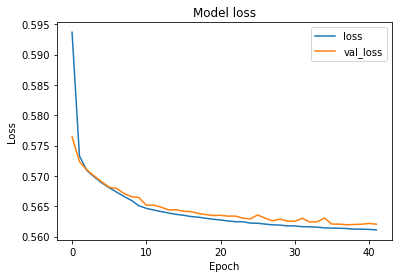

In [11]:
#plot training and validation loss for model
plt.plot(train_history.history['loss'], label='loss')
plt.plot(train_history.history['val_loss'], label='val_loss')
plt.title("Model loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
x_test_denoised = autoencoder.predict(x_test_filtered)
x_train_denoised = autoencoder.predict(x_train_filtered)

In [13]:
print(x_train_expanded.shape)
print(x_train_noisy.shape)
print(x_train_filtered.shape)
print(x_train_denoised.shape)

(50000, 32, 32, 3)
(50000, 32, 32, 3)
(50000, 32, 32, 3)
(50000, 32, 32, 3)


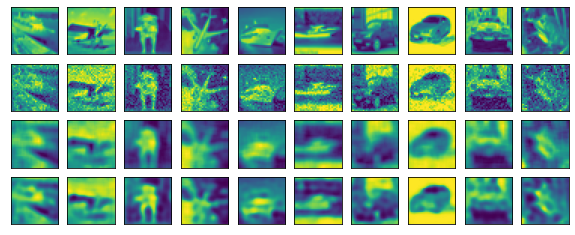

In [14]:
#Display a random noisy test images and corresponding denoised images predicted by our model
n = 10 #number of random images to display
plt.figure(figsize=(10, 4))
for i in range(n):
    size = len(x_train)
    index = np.random.randint(0, size)
    plt.subplot(4, n, i+1)
    plt.imshow(x_train_expanded[index, :, :, 0])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4, n, n+i+1)
    plt.imshow(x_train_noisy[index, :, :, 0])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4, n, 2*n+i+1)
    plt.imshow(x_train_filtered[index, :, :, 0])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4, n, 3*n+i+1)
    plt.imshow(x_train_denoised[index, :, :, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [15]:
result1 = test_classification(x_train_noisy, y_train, x_test_noisy, y_test)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6075 - accuracy: 0.4109 - val_loss: 1.3553 - val_accuracy: 0.5084
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2749 - accuracy: 0.5431 - val_loss: 1.2219 - val_accuracy: 0.5594
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1464 - accuracy: 0.5904 - val_loss: 1.1422 - val_accuracy: 0.5913
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0579 - accuracy: 0.6266 - val_loss: 1.1311 - val_accuracy: 0.5970
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9955 - accuracy: 0.6472 - val_loss: 1.0677 - val_accuracy: 0.6238
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9461 - accuracy: 0.6674 - val_loss: 1.0451 - val_accuracy: 0.6297
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9030 - accuracy: 0.6831 - val_loss: 1.0779 - val_accuracy:

In [16]:
result2 = test_classification(x_train_denoised, y_train, x_test_denoised, y_test)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6177 - accuracy: 0.4085 - val_loss: 1.4364 - val_accuracy: 0.4782
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3491 - accuracy: 0.5163 - val_loss: 1.3957 - val_accuracy: 0.4999
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2496 - accuracy: 0.5538 - val_loss: 1.2415 - val_accuracy: 0.5537
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1746 - accuracy: 0.5836 - val_loss: 1.2121 - val_accuracy: 0.5704
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1235 - accuracy: 0.6007 - val_loss: 1.1811 - val_accuracy: 0.5834
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0820 - accuracy: 0.6186 - val_loss: 1.1781 - val_accuracy: 0.5839
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0404 - accuracy: 0.6290 - val_loss: 1.1458 - val_accuracy:

In [17]:
print("Accuracy with noise :",result1[1]*100)
print("Accuracy after denoising :",result2[1]*100)

Accuracy with noise : 64.49999809265137
Accuracy after denoising : 59.18999910354614


In [18]:
im1 = tf.image.convert_image_dtype(x_train_noisy, tf.float32)
im2 = tf.image.convert_image_dtype(x_train_denoised, tf.float32)
psnr = tf.image.psnr(im1, im2, max_val=1.0)
psnr_train = np.mean(psnr)
print(psnr_train)

18.705269
